# Master Equation Solver: Single-Qubit Dynamics

In this notebook we will explore the dynamics of a single-qubit interacting with an environment. The evolution of the qubit state is governed by the Master equation. We will make use of the master equation solver qutip.mesolve implemented in qutip, to obtain the time-evolution of the qubit for different settings.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import Bloch, about, basis, mesolve, destroy, qeye

%matplotlib inline

# System setup

We will start with a basic Hamiltonian for a qubit driven by a classical field
$$H = -\frac{\Delta}{2}\sigma_z + \frac{\Omega}{2}\sigma_x,$$
where $\Delta = \omega - \omega_0$ is the detuning of the drive from qubit transition frequency, $\Omega$ is the strength of the drive. Here $\sigma_x = |e\rangle \langle g| + |g\rangle \langle e|$ and $\sigma_z = |e\rangle\langle e| - |g\rangle \langle g|$ are the Pauli matrices.

Additionally, we add a collapse operator that describes the dissipation of energy from the qubit to an external environment. The collapse operator is defined by
$$c = \sqrt{\gamma} \sigma_-$$

The expected time evolution of the qubit state follows the Lindblad form of the master equation given by
$$ \dot{\rho} = - i[H, \rho] + \mathcal{D}[c]\rho$$
where
$$\mathcal{D}[a]\rho \equiv a\rho a^\dagger - \frac{1}{2}\{\rho, a^\dagger a\}$$

We use the following standard notations to define qubit operators

In [2]:
ket_e = basis(2, 1)
ket_g = basis(2, 0)

sm = destroy(2)
sp = sm.dag()

sx = sp + sm
sy = -1j * (sp - sm)
sz = 2 * sp * sm - qeye(2)

In [3]:
sz

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[-1.  0.]
 [ 0.  1.]]

# Time Evolution

Let us assume that $\Omega = \Delta = 0$.

## Population Decay

We initialize the qubit in its excited state $|e\rangle$. Assume that $\gamma = (10\:\mathrm{\mu s})^{-1}$. Then, the time evolution will be given by

In [4]:
psi0 = ket_e
H = qeye(2) * 0.0
gamma = 1 / 10e-6

tlist = np.linspace(0, 100e-6, 100)

result = mesolve(H, psi0, tlist, [np.sqrt(gamma) * sm], [sx, sy, sz])

### Visualization in the Bloch sphere

Text(0, 0.5, 'Expectation Value')

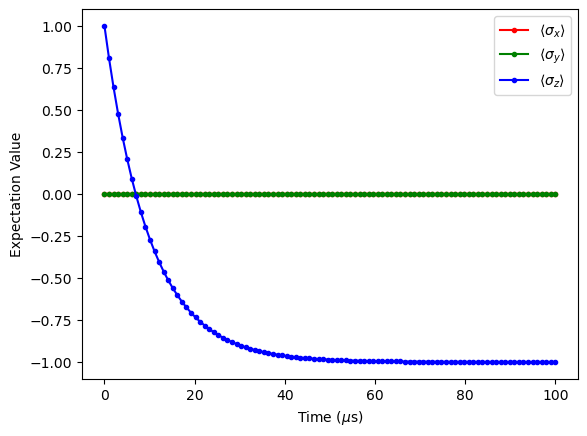

In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist / 1e-6, result.expect[0], label = r'$\langle\sigma_x\rangle$', marker='.', color='red')
ax.plot(tlist / 1e-6, result.expect[1], label = r'$\langle\sigma_y\rangle$', marker='.', color='green')
ax.plot(tlist / 1e-6, result.expect[2], label = r'$\langle\sigma_z\rangle$', marker='.', color='blue')
ax.legend(loc = 0)
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Expectation Value')

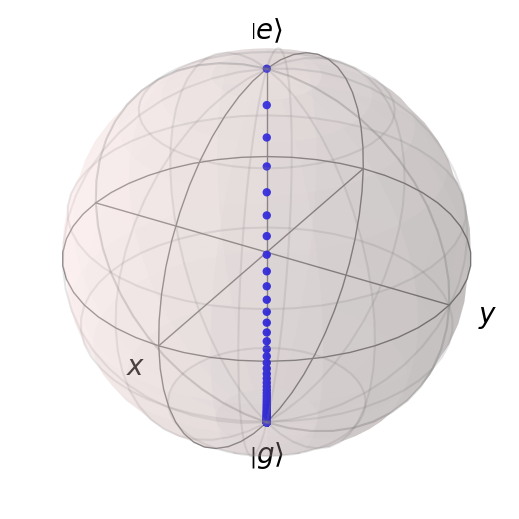

In [6]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|e\right>$', r'$\left|g\right>$']
sphere.add_points(result.expect, meth="s")
sphere.show()

### Extracting the $T_1$ relaxation time from Data

Let's use `scipy.optimize.curve_fit` to fit the $\langle\sigma_z\rangle$ curve and extract the relaxation time $T_1$.

In [7]:
from scipy.optimize import curve_fit

def decay_fit_func(t, T, a, b):
    return a + b * np.exp(-t / T)

popt, pcov = curve_fit(decay_fit_func, tlist, result.expect[-1], p0 = [1.0e-6, -1, 2])

Text(0.5, 1.0, '$T_1 = 10.000 \\pm 0.000\\:\\mu s$ ')

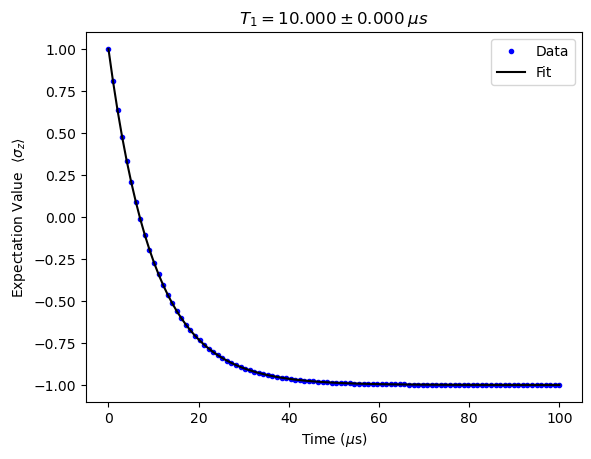

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist / 1e-6, result.expect[-1], marker='.', lw=0, label = 'Data', color='blue')
ax.plot(tlist / 1e-6, decay_fit_func(tlist, *popt), label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Expectation Value  ' + r'$\langle \sigma_z\rangle$')
ax.set_title(f'$T_1 = {(popt[0] / 1e-6):.3f} \pm {(np.sqrt(pcov[0,0]) / 1e-6):.3f}\:\mu s$ ')

As expected the extracted $T_1$ value is the inverse of the qubit relaxation rate $\gamma$.

## Decay-Induced Dephasing

In order to characterize the rate of dephasing (rate of decay of off-diagonal element of density matrix), we initialize the qubit in the superposition state $|\psi_0\rangle = \frac{1}{\sqrt{2}}(|g\rangle + |e\rangle)$.

In [9]:
psi0 = (ket_g + ket_e) / np.sqrt(2)
H = qeye(2) * 0.0
gamma = 1 / 10e-6

tlist = np.linspace(0, 100e-6, 100)

result1 = mesolve(H, psi0, tlist, [np.sqrt(gamma) * sm], [sx, sy, sz])

Text(0, 0.5, 'Expectation Value')

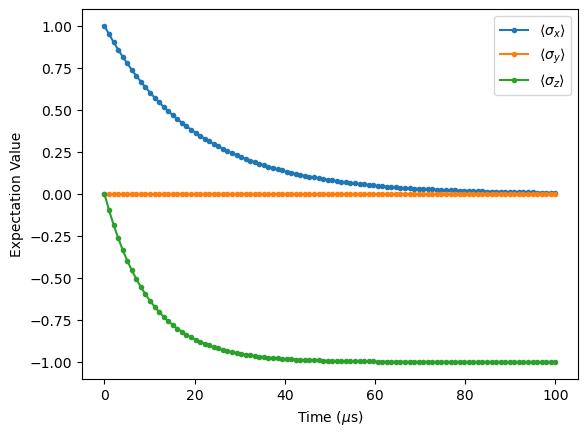

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist / 1e-6, result1.expect[0], label = r'$\langle\sigma_x\rangle$', marker='.')
ax.plot(tlist / 1e-6, result1.expect[1], label = r'$\langle\sigma_y\rangle$', marker='.')
ax.plot(tlist / 1e-6, result1.expect[2], label = r'$\langle\sigma_z\rangle$', marker='.')
ax.legend(loc = 0)
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Expectation Value')

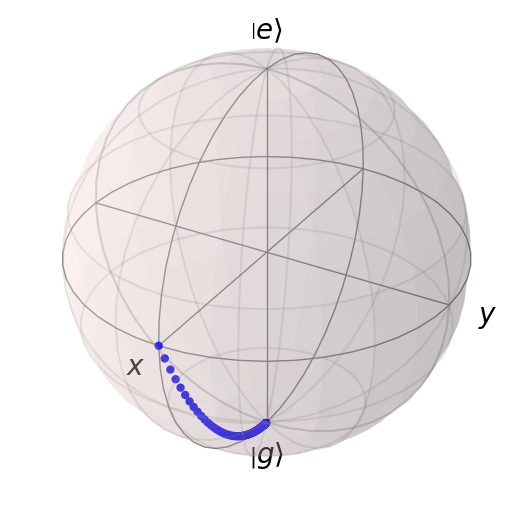

In [11]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|e\right>$', r'$\left|g\right>$']
sphere.add_points(result1.expect, meth="s")
sphere.show()

### Extracting the $T_2$ coherence time from Data

The $T_2$ coherence time can be obtained by fitting the decay of $\langle \sigma_x\rangle = \rho_{ge} + \rho_{eg}$ as a function of time.

In [12]:
# fit the decay of sigma x expectation value
popt1, pcov1 = curve_fit(decay_fit_func, tlist, result1.expect[0], p0 = [1.0e-6, 1, 1])

Text(0.5, 1.0, '$T_2 = 20.000 \\pm 0.000\\:\\mu s$ ')

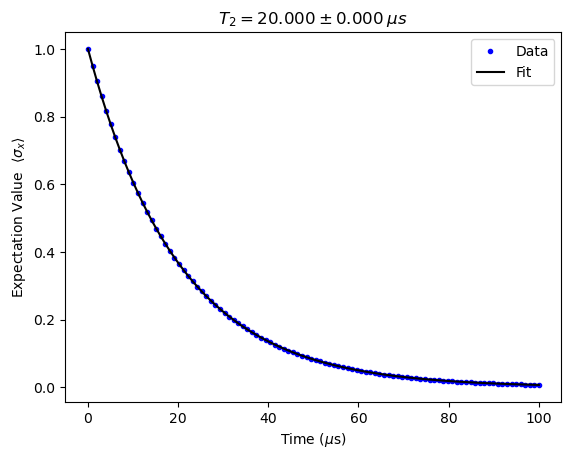

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist / 1e-6, result1.expect[0], marker='.', lw=0, label = 'Data', color='blue')
ax.plot(tlist / 1e-6, decay_fit_func(tlist, *popt1), label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Expectation Value  ' + r'$\langle \sigma_x\rangle$')
ax.set_title(f'$T_2 = {(popt1[0] / 1e-6):.3f} \pm {(np.sqrt(pcov1[0,0]) / 1e-6):.3f}\:\mu s$ ')

As can be seen here, we obtain the $T_1$-limited coherence time $T_2 = 2T_1 = 2 / \gamma$.

## Pure Dephasing

In realistic settings, the frequency fluctuation of qubit (fluctuation of $\Delta$) causes qubits to lose dephase at rates rates much larger than the decay-induced dephasing rate $\Gamma_1 / 2$.

Assume that there is a quasi-static fluctuation of qubit frequency, causing round-to-round fluctuation of $\Delta$. This can be modeled as a collapse operator $𝑐_\varphi=\sqrt{\frac{\gamma_\varphi}{2}}\sigma_z$ where $\gamma_\varphi$ is the pure dephasing rate. Assume for now that $\gamma_\varphi = (2\:\mu\mathrm{s})^{-1}$.

In [14]:
psi0 = (ket_g + ket_e) / np.sqrt(2)
H = qeye(2) * 0.0
gamma = 1 / 10e-6
g_phi = 1 / 2e-6

tlist = np.linspace(0, 100e-6, 100)

result2 = mesolve(H, psi0, tlist, [np.sqrt(gamma) * sm, np.sqrt(g_phi / 2) * sz], [sx, sy, sz])

Text(0, 0.5, 'Expectation Value')

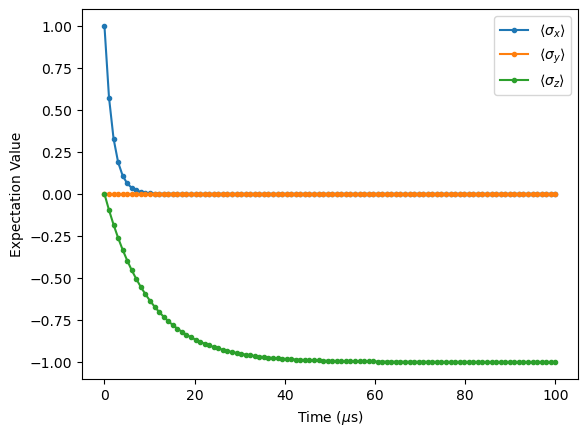

In [15]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist / 1e-6, result2.expect[0], label = r'$\langle\sigma_x\rangle$', marker='.')
ax.plot(tlist / 1e-6, result2.expect[1], label = r'$\langle\sigma_y\rangle$', marker='.')
ax.plot(tlist / 1e-6, result2.expect[2], label = r'$\langle\sigma_z\rangle$', marker='.')
ax.legend(loc = 0)
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Expectation Value')

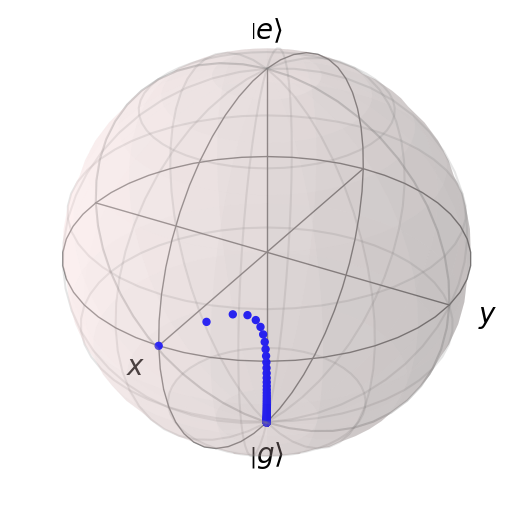

In [16]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|e\right>$', r'$\left|g\right>$']
sphere.add_points(result2.expect, meth="s")
sphere.show()

Here, we observe that the $\langle \sigma_x\rangle$ decays quickly to zero, followed by the slow decay of $\langle \sigma_z\rangle$ to -1 (ground state).

### Extracting the decay rate of $\langle \sigma_x\rangle$, $\langle \sigma_z\rangle$

In [17]:
# fit the decay of sigma x and z expectation value
popt2x, pcov2x = curve_fit(decay_fit_func, tlist, result2.expect[0], p0 = [1.0e-6, 1, 1])
popt2z, pcov2z = curve_fit(decay_fit_func, tlist, result2.expect[2], p0 = [1.0e-6, 1, 1])

Text(0.5, 1.0, '$T_1 = 10.00 \\pm 0.00\\:\\mu s$, $T_2 = 1.82 \\pm 0.00\\:\\mu s$')

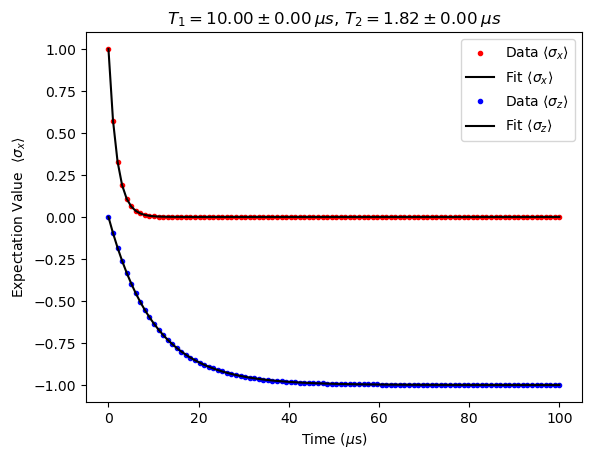

In [18]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist / 1e-6, result2.expect[0], marker='.', lw=0, label = r'Data $\langle\sigma_x\rangle$', color='red')
ax.plot(tlist / 1e-6, decay_fit_func(tlist, *popt2x), label = r'Fit $\langle\sigma_x\rangle$', color='black')

ax.plot(tlist / 1e-6, result2.expect[2], marker='.', lw=0, label = r'Data $\langle\sigma_z\rangle$', color='blue')
ax.plot(tlist / 1e-6, decay_fit_func(tlist, *popt2z), label = r'Fit $\langle\sigma_z\rangle$', color='black')

ax.legend()
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Expectation Value  ' + r'$\langle \sigma_x\rangle$')
ax.set_title(
    f'$T_1 = {(popt2z[0] / 1e-6):.2f} \pm {(np.sqrt(pcov2z[0,0]) / 1e-6):.2f}\:\mu s$' + ', ' +
    f'$T_2 = {(popt2x[0] / 1e-6):.2f} \pm {(np.sqrt(pcov2x[0,0]) / 1e-6):.2f}\:\mu s$'
)

Therefore, the addition of collapse operator $𝑐_\varphi=\sqrt{\frac{\gamma_\varphi}{2}}\sigma_z$ decreases the coherence time $T_2$ while preserving $T_1$. This process is called the pure dephasing.

The new $T_2$ value can be understood from 
$$
\Gamma_2 = \frac{\Gamma_1}{2} + \Gamma_\varphi
$$
where $\Gamma_1 = 1/T_1$ is the relaxation rate of the qubit, $\Gamma_\varphi = \gamma_\varphi$ is the pure dephasing rate of the qubit.

In [19]:
# new T2 value from theory
1 / (gamma / 2 + g_phi)

1.818181818181818e-06

## Effect of decoherence on Rabi oscillation

Assume that we apply a strong drive to the qubit of $\Omega = 2\pi \times 1\:\mathrm{MHz}$. How will the time evolution look like in  this case?

In [20]:
psi0 = ket_g
Omega = 2 * np.pi * 1e6
H = Omega / 2 * sx
gamma = 1 / 10e-6
g_phi = 1 / 2e-6

tlist = np.linspace(0, 10e-6, 1000)

result3 = mesolve(H, psi0, tlist, [np.sqrt(gamma) * sm, np.sqrt(g_phi / 2) * sz], [sx, sy, sz])

Text(0, 0.5, 'Expectation Value')

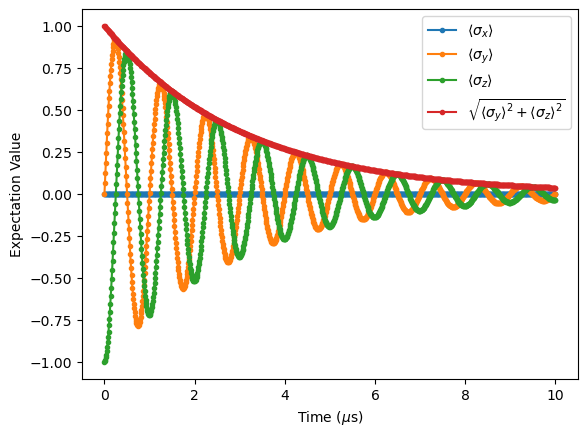

In [21]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist / 1e-6, result3.expect[0], label = r'$\langle\sigma_x\rangle$', marker='.')
ax.plot(tlist / 1e-6, result3.expect[1], label = r'$\langle\sigma_y\rangle$', marker='.')
ax.plot(tlist / 1e-6, result3.expect[2], label = r'$\langle\sigma_z\rangle$', marker='.')
ax.plot(tlist / 1e-6, np.sqrt(result3.expect[1] ** 2 + result3.expect[2] ** 2) ,
        label = r'$\sqrt{\langle\sigma_y\rangle^2 + \langle\sigma_z\rangle^2} $', marker='.')
ax.legend(loc = 0)
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Expectation Value')

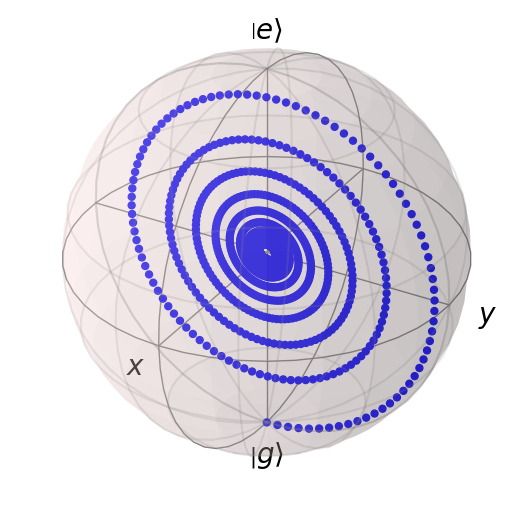

In [22]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|e\right>$', r'$\left|g\right>$']
sphere.add_points(result3.expect, meth="s")
sphere.show()

The classical drive term $\frac{\Omega}{2}\sigma_x$ causes Bloch vector to rotate about the x axis of the Bloch sphere. Under the effect of decoherence, strong classical drive causes qubit to converge to a classical mixture of the excited  and the ground states with equal probability of 1/2. 

### Extracting the decay rate of Rabi oscillation amplitude

The oscillation envelope is given by $\langle\sigma_\perp\rangle = \sqrt{\langle\sigma_y\rangle^2 + \langle\sigma_z\rangle^2}$

In [23]:
env = np.sqrt(result3.expect[1] ** 2 + result3.expect[2] ** 2)

# fit the decay of sigma x and z expectation value
popt3, pcov3 = curve_fit(decay_fit_func, tlist, env, p0 = [1.0e-6, 1, 1])


Text(0.5, 1.0, '$T_\\mathrm{Rabi} = 3.054 \\pm 0.000\\:\\mu s$ ')

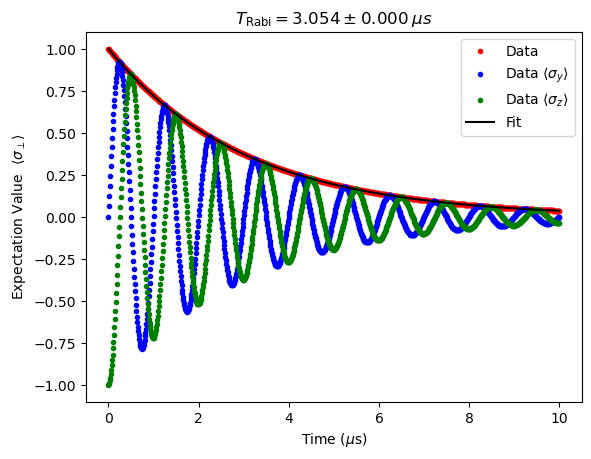

In [24]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist / 1e-6, env, marker='.', lw=0, label = 'Data', color='red')
ax.plot(tlist / 1e-6, result3.expect[1], marker='.', lw=0, label = r'Data $\langle\sigma_y\rangle$', color='blue')
ax.plot(tlist / 1e-6, result3.expect[2], marker='.', lw=0, label = r'Data $\langle\sigma_z\rangle$', color='green')
ax.plot(tlist / 1e-6, decay_fit_func(tlist, *popt3), label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Expectation Value  ' + r'$\langle \sigma_\perp\rangle$')
ax.set_title(r'$T_\mathrm{Rabi}' + f' = {(popt3[0] / 1e-6):.3f} \pm {(np.sqrt(pcov3[0,0]) / 1e-6):.3f}\:\mu s$ ')

How do we understand this decay time?
Intuitively, we could say that the bloch vector stays along the longitudinal direction half the time and the transverse direction the other half of the time during the evolution. Therefore,
$$\Gamma_\textrm{Rabi} \approx \frac{\Gamma_1}{2} + \frac{\Gamma_2}{2} = \frac{3}{4}\Gamma_1 + \frac{\Gamma_\varphi}{2}$$

In [25]:
1 / (3 / 4 * gamma + 1 / 2 * g_phi)

3.076923076923077e-06

In the end the Rabi oscillation visibility depends strongly on the coherence time $T_2$ of the qubit. Therefore, achieving high-fidelity gate is contingent upon high coherence time.

# Time-dependent Hamiltonian

Refer to the QuTiP documentation about time-dependent Hamiltonian problems : https://qutip.org/docs/latest/guide/dynamics/dynamics-time.html

For creation of $\pi$-pulses, it is important to shape the pulse properly in order to limit the bandwidth of the pulse. This is because larger bandwidth can cause significant leakage into states outside the qubit manifold (computational basis), as physical realizations of qubits often involve multi-level structure. We can try to create a time-dependent problem by performing the following

```
def H1_coeff(t, args):
    return 9 * np.exp(-(t / 5.) ** 2)
   
H = [H0,[H1, H1_coeff]]
output = mesolve(H, psi0, t, c_ops, [ada, sigma_UU, sigma_GG])
```

Let's try to create situation where a Gaussian XY pulse is applied to a qubit:
$$\Omega(t) = \frac{A}{\sqrt{2\pi}\sigma} \exp{\left(-\frac{(t - T/ 2)^2}{2\sigma^2}\right)}$$

In [56]:
def H1_coeff(t, args):
    A = args['A']
    sig = args['sigma']
    T = args['T']
    return A / np.sqrt(2 * np.pi * sig **2) * np.exp(-(t - T / 2) ** 2 / (2 * sig **2))

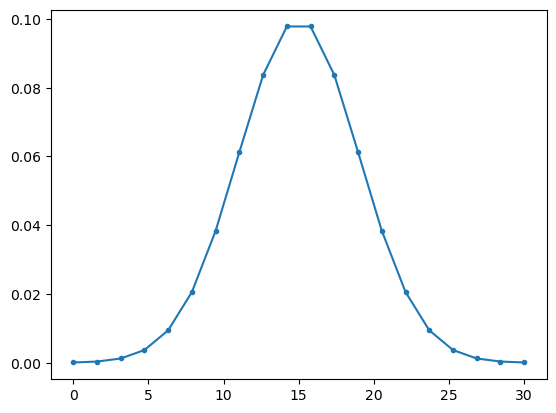

In [41]:
# pulse shape example
args = {
    'A': 1.0,   # pulse amplitude factor
    'sigma': 4, # sigma of Gaussian
    'T': 30      # duration of pulse (good to choose > 4 * sigma)
}

t = np.linspace(0, args['T'], 20)
plt.figure()
plt.plot(t, H1_coeff(t, args), '.-')


In [42]:
from qutip import Options

In [53]:
psi0 = ket_g

H0 = 0.0 * qeye(2)
H1 = 1 / 2 * sx

gamma = 1 / 10 # unit of time: us
g_phi = 1 / 2

T = 0.1  # pulse duration
args = {
    'A': np.pi,
    'T': T,
    'sigma': T / 5
}

tlist = np.linspace(0, T, 100)

H = [H0, [H1, H1_coeff]]
result4 = mesolve(
    H, psi0, tlist,
    [np.sqrt(gamma) * sm, np.sqrt(g_phi / 2) * sz], [sx, sy, sz], args = args
)

Text(0, 0.5, 'Expectation Value')

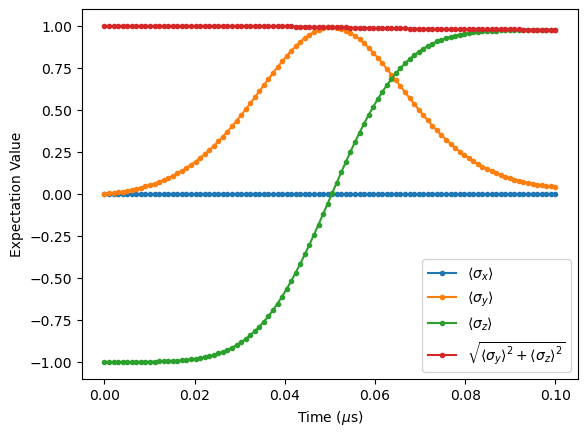

In [54]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result4.expect[0], label = r'$\langle\sigma_x\rangle$', marker='.')
ax.plot(tlist, result4.expect[1], label = r'$\langle\sigma_y\rangle$', marker='.')
ax.plot(tlist, result4.expect[2], label = r'$\langle\sigma_z\rangle$', marker='.')
ax.plot(tlist, np.sqrt(result4.expect[1] ** 2 + result4.expect[2] ** 2) ,
        label = r'$\sqrt{\langle\sigma_y\rangle^2 + \langle\sigma_z\rangle^2} $', marker='.')
ax.legend(loc = 0)
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Expectation Value')

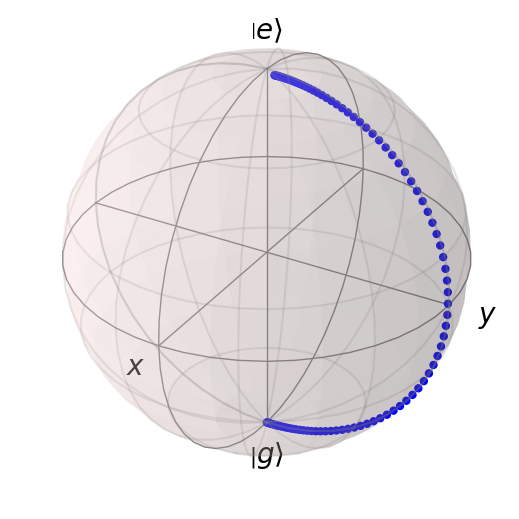

In [55]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|e\right>$', r'$\left|g\right>$']
sphere.add_points(result4.expect, meth="s")
sphere.show()

This corresponds to a realization of $\pi$-pulse.